## Objective
Create saliency map of training samples to visualize what model looks for in input

In [1]:
%load_ext autoreload
%autoreload

# Update PATH to allow imports
import sys
sys.path.append("/data/MEAprojects/DLSpikeSorter")

# Imports
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from pathlib import Path
import torch
import numpy as np
from src.model import ModelSpikeSorter
from src.utils import random_seed
from src import data, meta

In [2]:
model = ModelSpikeSorter.load(meta.ORGANOID_MODELS[2])
cross_val = data.RecordingCrossVal(
    samples_per_waveform=1, front_buffer=model.buffer_front_sample, end_buffer=model.buffer_end_sample,
    num_wfs_probs=[0, 1],
    isi_wf_min=3, isi_wf_max=None,
    rec_paths=meta.ORGANOID[:], thresh_amp=3*meta.GAIN_TO_UV, use_positive_peaks=True,
    thresh_std=0.6,
    sample_size=model.sample_size, start=0, ms_before=3, ms_after=3, gain_to_uv=meta.GAIN_TO_UV,
    device="cuda", dtype=torch.float16, mmap_mode="r",
    as_datasets=True,
    num_workers=0, shuffle=True, batch_size=1
)
rec, train, val = cross_val["2954"]

Using random seed 34
34


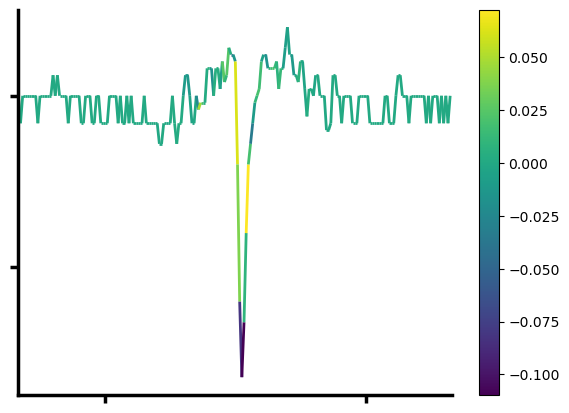

In [3]:
XTICKS = [40, 160]
XLIM = [0, 200]
YTICKS = [0, -50]

from pathlib import Path
SVG_PATH = "/data/MEAprojects/DLSpikeSorter/models/v0_4_4/2954/230101_134042_729459/saliency_maps/34.svg"
SVG_PATH = Path(SVG_PATH)
TICKS_PATH = SVG_PATH.parent / f"{SVG_PATH.name.split('.')[0]}_ticks.txt"  # Where to save ticks
SVG_PATH.parent.mkdir(exist_ok=True, parents=True)

# for sample_idx in range(len(val)):
for sample_idx in [34]:
    random_seed(sample_idx)
    print(sample_idx)
    # random_seed(sample_idx) 
    ## 
    sample = val[sample_idx]
    loc = sample[2].item()
    sample = sample[0].flatten()
    
    # Plot original sample
    plt.plot(sample.cpu())
    YLIM = plt.ylim()
    plt.close()
    # plt.show()

    trace = sample.flatten()
    trace.requires_grad = True
    output = model(trace[None, None, :])
    pred = model.outputs_to_preds(output.detach())[0]
    if len(pred) == 0:
        continue
    pred = pred[0]

    output[0, model.loc_to_logit(pred)].backward()
    grad = trace.grad.cpu().numpy()
    trace = trace.flatten().detach().cpu().numpy()

    fig, ax = plt.subplots(1, figsize=(7, 5))

    trace_x = np.arange(trace.size)  # np.linspace(0, trace.size, 10000)
    trace_points = np.array([trace_x, trace]).T.reshape(-1, 1, 2)
    trace_segments = np.concatenate([trace_points[:-1], trace_points[1:]], axis=1)

    trace_lc = LineCollection(trace_segments, cmap="viridis", linewidths=2)
    trace_lc.set_array(grad)
    line = ax.add_collection(trace_lc)
    fig.colorbar(line, ax=ax)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Increase thickness of the bottom and left spines
    ax.spines["bottom"].set_linewidth(2.5)
    ax.spines["left"].set_linewidth(2.5)

    # Increase thickness of tick marks
    ax.tick_params(axis='both', direction='out', length=6, width=2.5, colors='black')

    # Hide labels
    ax.set_title("")
    ax.set_xlabel("")
    ax.set_ylabel("")

    # Update ticks
    if XTICKS is not None:
        ax.set_xticks(XTICKS, [''] * len(XTICKS))
        if XLIM is None:
            ax.set_xlim(XTICKS[0], XTICKS[-1])
        else:
            ax.set_xlim(*XLIM)
    if YTICKS is not None:
        ax.set_yticks(YTICKS, [''] * len(YTICKS))
        if YLIM is None:
            ax.set_ylim(YTICKS[0], YTICKS[-1])
        else:
            ax.set_ylim(*YLIM)
    
    # axs.axvline(loc)
    
    # plt.savefig(SVG_PATH, format="svg")
    # # Save ticks
    # with open(TICKS_PATH, "w") as file:
    #     file.write(f"x-ticks: {XTICKS}\ny-ticks: {YTICKS}")
        
    plt.show()